In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns

from os.path import join

plt.style.use(["seaborn", "thesis"])
plt.rcParams['figure.figsize'] = (8, 4)

/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Fetch Dataset 

In [2]:
from SCFInitialGuess.utilities.dataset import AbstractDataset


data_path = "../../dataset/EthenT/"
postfix = "EthenT"
dim = 72
basis = "6-311++g**"
n_electrons = 16
#data_path = "../butadien/data/"
#postfix = ""
#dim = 26


S = np.load(join(data_path, "S" + postfix + ".npy"))
P = np.load(join(data_path, "P" + postfix + ".npy"))

index = np.load(join(data_path, "index" + postfix + ".npy"))

molecules = np.load(join(data_path, "molecules" + postfix + ".npy"))


ind = int(0.8 * len(index))
ind_val = int(0.8 * ind)


molecules = (
    molecules[:ind_val], 
    molecules[ind_val:ind], 
    molecules[ind:]
)

s_triu_norm, mu, std = AbstractDataset.normalize(S)


def split(x, y, ind):
    return x[:ind], y[:ind], x[ind:], y[ind:]

s_train, p_train, s_test, p_test = split(S, P, ind)
s_train, p_train, s_val, p_val = split(s_train, p_train, ind_val)

#  Define Candidates

In [3]:
from SCFInitialGuess.descriptors.coordinate_descriptors import behler_cutoff_1

def plot_cutoff_model(model, R_c, t=None):
    mus, sigmas = model
    
    if t is None:
        t = np.linspace(0, 1.2 * R_c, 200)
    
    for r_s, eta in zip(mus, sigmas):
        plt.plot(
            t, 
            np.exp(-1 * eta*(t - r_s)**2) * \
            behler_cutoff_1(t, R_c)
        )

def plot_damped_model(model, tau, t=None):
    mus, sigmas = model
    
    if t is None:
        t = np.linspace(0, 1.2 * tau, 200)
    
    for r_s, eta in zip(mus, sigmas):
        plt.plot(
            t, 
            np.exp(-1 * eta*(t - r_s)**2) * \
            np.exp(- t / tau)
        )
        
def plot_normal_model(model, t):
    for r_s, eta in zip(model[0], model[1]):
        plt.plot(t, np.exp(-1 * eta*(t - r_s)**2))
        
def plot_periodic_model(model, t):
    period = model[2]
    for r_s, eta in zip(model[0], model[1]):
        plt.plot(t,
            np.exp(-1 * eta * ((t % period) - r_s)**2) + \
            np.exp(-1 * eta * ((t % period) - period - r_s)**2)
        )

## Radial


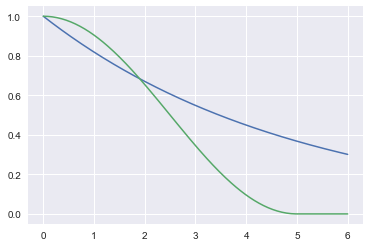

In [7]:
x = np.linspace(0, 6, 200)
plt.plot(x, np.exp(-x / 5))
plt.plot(x, behler_cutoff_1(x, 5))
plt.show()

### Origin Centered 

In [8]:
r_model_origin = (
    [0.0] * 20,
    np.linspace(10, 0.1, 20)
)


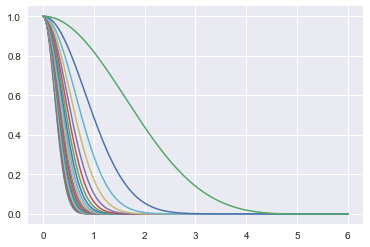

In [9]:
plot_cutoff_model(r_model_origin, 5)

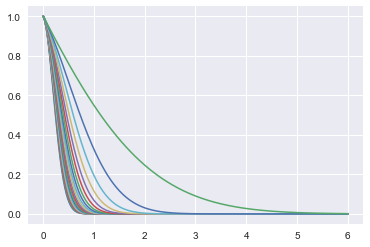

In [10]:
plot_damped_model(r_model_origin, 2, np.linspace(0, 5*1.2, 200))

### Evenly distributed 

In [11]:
r_model_evenly = (
    np.linspace(0.1,4, 20),
    np.linspace(30, 10, 20),
)

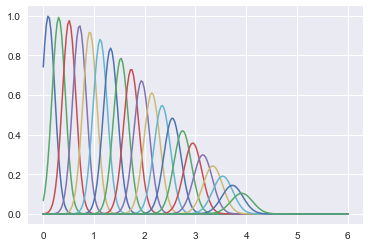

In [12]:
plot_cutoff_model(r_model_evenly, 5)

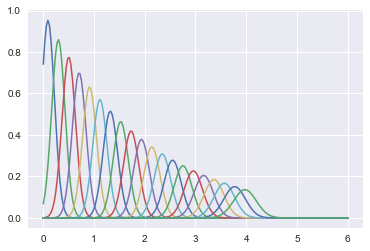

In [13]:
plot_damped_model(r_model_evenly, 2, np.linspace(0, 5*1.2, 200))

### Highest density around average bonding length

In [14]:
r_model_concentrated = (
    list(np.linspace(0.2, 0.6, 3)) + \
    list(np.linspace(0.7, 1.7, 10)) + \
    list(np.linspace(1.85, 4, 7)),
    [20]*20,
)

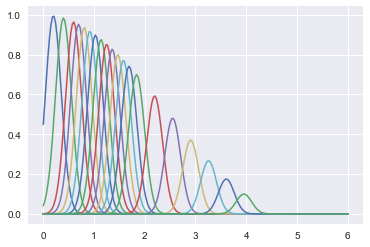

In [15]:
plot_cutoff_model(r_model_concentrated, 5)

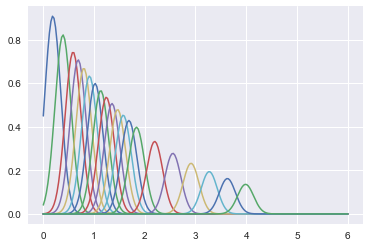

In [16]:
plot_damped_model(r_model_concentrated, 2, np.linspace(0, 5*1.2, 200))

## Aizimutahl 

In [17]:
phi_model_evenly = (
    np.linspace(0, 2*np.pi, 20),
    [10] * 20,
    2 * np.pi
)

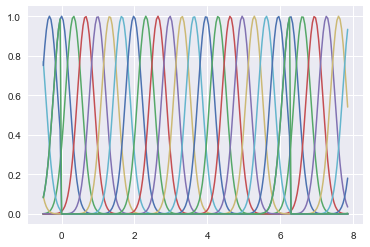

In [18]:
plot_periodic_model(phi_model_evenly, np.linspace(-0.5, 2.5*np.pi, 200))

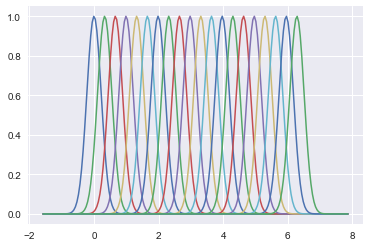

In [19]:
plot_normal_model(phi_model_evenly, np.linspace(-0.5*np.pi, 2.5*np.pi, 200))

### Polar, das gleiche wie bei Azimuthal 

In [20]:
theta_model_evenly = (
    np.linspace(0, np.pi, 10),
    [10] * 10,
    np.pi
)

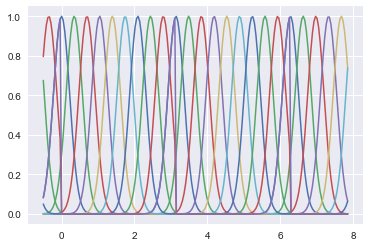

In [21]:
plot_periodic_model(theta_model_evenly, np.linspace(-0.5, 2.5*np.pi, 200))

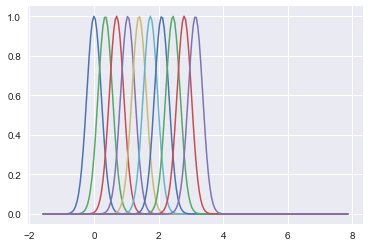

In [22]:
plot_normal_model(theta_model_evenly, np.linspace(-0.5*np.pi, 2.5*np.pi, 200))


# Train Benchmarksystem 

## Utilities 

In [23]:
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS
from SCFInitialGuess.descriptors.coordinate_descriptors import \
    AtomicNumberWeighted, Gaussians
from SCFInitialGuess.descriptors.coordinate_descriptors import \
    Gaussians, RADIAL_GAUSSIAN_MODELS, AZIMUTHAL_GAUSSIAN_MODELS, POLAR_GAUSSIAN_MODELS
from SCFInitialGuess.utilities.dataset import extract_triu
from SCFInitialGuess.utilities.dataset import StaticDataset




def make_mask(mol, species):

    masks = []
    current_dim = 0
    for atom in mol.species:
        # calculate block range
        index_start = current_dim
        current_dim += N_BASIS[mol.basis][atom] 
        index_end = current_dim

        if atom == species:

            # calculate logical vector
            L = np.arange(dim)
            L = np.logical_and(index_start <= L, L < index_end)

            masks.append(np.logical_and.outer(L, L))
            
    
    return masks



def extract_dataset(molecules, p_batch, descriptor, species):    
    
    # make mask to extract central blocks
    masks = make_mask(molecules[0], species)
    
    descriptor_values, blocks = [], []
    for p, mol in zip(p_batch, molecules):
        for mask in masks:
            blocks.append(extract_triu(
                p.copy()[mask], 
                N_BASIS[mol.basis][species]
            ))
        
        for i, atom in enumerate(mol.species):
            if atom == species:
                descriptor_values.append(
                    descriptor.calculate_atom_descriptor(
                        i, 
                        mol,
                        descriptor.number_of_descriptors
                    )
                )
            
    return descriptor_values, blocks


def make_dataset(descriptor, species, dim):
    
    inputs_test, outputs_test = extract_dataset(
        molecules[2], 
        p_test.reshape(-1, dim, dim),
        descriptor,
        species
    )
    
    inputs_validation, outputs_validation = extract_dataset(
        molecules[1], 
        p_val.reshape(-1, dim, dim),
        descriptor,
        species
    )

    inputs_train, outputs_train = extract_dataset(
        molecules[0], 
        p_train.reshape(-1, dim, dim),
        descriptor,
        species
    )
    
    
    _, mu, std = StaticDataset.normalize(inputs_train + inputs_validation + inputs_test)
    
    dataset = StaticDataset(
        train=(
            StaticDataset.normalize(inputs_train, mu, std)[0], 
            np.asarray(outputs_train)
        ),
        validation=(
            StaticDataset.normalize(inputs_validation, mu, std)[0], 
            np.asarray(outputs_validation)
        ),
        test=(
            StaticDataset.normalize(inputs_test, mu, std)[0], 
            np.asarray(outputs_test)
        ),
        mu=mu,
        std=std
    )
    
    return dataset

### NN 

In [24]:
intializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01)

def make_model( 
        input_dim, 
        output_dim,
        activation="elu", 
        learning_rate=1e-5
    ):

    model = keras.Sequential()

    # linear model => 1 layer
    
    model.add(keras.layers.Dense(
        output_dim, 
        #activation=activation, 
        input_dim=input_dim, 
        kernel_initializer=intializer, 
        #bias_initializer='zeros',
        kernel_regularizer=keras.regularizers.l2(1e-8)
    ))


    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate), 
        loss='MSE', 
        metrics=['mae', 'mse']
    )
    
    return model



In [25]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_mean_squared_error", 
    min_delta=1e-10, 
    patience=200, 
    verbose=1
)

EPOCHS = 5000

def train_model(model, dataset, learning_rate=1e-3, epochs=EPOCHS):
    
    history = model.fit(
        x = dataset.training[0],
        y = dataset.training[1],
        epochs=epochs,
        shuffle=True,
        validation_data=dataset.validation, 
        verbose=0, 
        callbacks=[
            early_stopping, 
        ]
    )

    ind = np.argmax(history.history["val_mean_squared_error"])

    return history.history["mean_squared_error"][ind], history.history["val_mean_squared_error"][ind]
    

### Benchmarking

In [26]:
DIM = {
    "H": int(7*8 / 2),
    "C": int(22 * 23 / 2)
}

def run_test(descriptor, n_tests=5, species="C"):
    
    dataset = make_dataset(descriptor, species, dim)
    
    errors_train, errors_val = [], []
    for i in range(n_tests):
        print("--> Training: " + str(i+1))
        
        keras.backend.clear_session()
        
        model = make_model(descriptor.number_of_descriptors, DIM[species])
        
        errors = train_model(model, dataset)
        errors_train.append(errors[0])
        errors_val.append(errors[1])
        print("--> Result: Train: {:0.4e} Vaidation: {:0.4e}".format(errors[0], errors[1]))
        
        
        
    return errors_train, errors_val

In [28]:
from SCFInitialGuess.descriptors.coordinate_descriptors import NonWeighted, AtomicNumberWeighted
from SCFInitialGuess.descriptors.coordinate_descriptors import Gaussians, PeriodicGaussians
from SCFInitialGuess.descriptors.coordinate_descriptors import IndependentAngularDescriptor, SPHAngularDescriptor
from SCFInitialGuess.descriptors.coordinate_descriptors import BehlerCutoff1, Damping

N_TESTS = 5

angular_descriptor_list = [
    IndependentAngularDescriptor(
        PeriodicGaussians(*phi_model_evenly), 
        PeriodicGaussians(*theta_model_evenly)
    ),
    SPHAngularDescriptor(3),
    SPHAngularDescriptor(5)
]

counter = 0
results = []
for r_model in [r_model_origin, r_model_evenly, r_model_concentrated]:
    for HighLevelDescriptor in [NonWeighted, AtomicNumberWeighted]:
        for angular_descriptor in angular_descriptor_list:
            for CutOff in [BehlerCutoff1(5), Damping(2)]:

                counter += 1

                print("\n\nTesting model: {0}".format(counter))

                descriptor = HighLevelDescriptor(
                    Gaussians(*r_model),
                    angular_descriptor,
                    CutOff
                )

                errors_train, errors_val = run_test(descriptor)
                results.append((
                    [counter] * N_TESTS,
                    errors_train,
                    errors_val
                ))


            
            
            
            
            
            



Testing model: 1
--> Training: 1


KeyboardInterrupt: 

# TODO: add spherical harmonics!!! 

In [ ]:
labels = []
x_data = []
y_train = []
y_val = []
for x, train, val in results:
    labels.append("Model {0}".format(x[0]))
    
    x_data += x
    y_train += train
    y_val += val

In [ ]:
plt.scatter(x_data, y_train, label="Train")
plt.scatter(x_data, y_val, label="Validation")
plt.ylim(0.0075, 0.013)
plt.xticks(np.arange(1, 13), labels, rotation=-60)
plt.legend()
plt.tight_layout()

plt.savefig("/home/jcartus/Repos/MastersThesis/AtomicBlocks/figures/DescriptorBenchmark.pdf")

plt.show()

